\title{ Ion Tech GFC-1000 Mass Flow Controller Controlled with Python via RS-232}
\author{Steven K Armour}
\maketitle

The goal of this program/notebook is to develop a program that can control and log a circa ~1988 3 Channel mass flow controller. Since this mass flow controller was developed before the SCPI standardized it uses custom RS-232 commands and thus is it vary unlikely that this equipment is supported by a VISA library. Thus custom programming is necessary.

Needed hardware:
+ Ion Tech GFC-1000 Mass Flow controller 
+ USB to db9 RS-232 converter
+ db9 to db25 converter

# Libraries used

In [1]:
import serial #implements rs-232 com
import pandas as pd # data collection
import numpy as np
import threading #used for mutlti threading
import matplotlib.pyplot as plt
import pickle
import time

# Setting up the rs-232 communication ports
+ for a windows machine go to device manager setting and determine what com port the usb to rs-232 cable is connected to

+ for a mac machine: ????????

+ for a linux ubuntu machine open a terminal and review the the list of connections to the computer via typing in the terminal
```ls -l  /dev/tty*```
at the end list one should see ```/dev/ttyUSB``` with an ending number of the USB port. After selecting the appropriate port one will typically need to unlock the port via 
``` sudo chmod 666  /dev/ttyUSB```

In [2]:
UnLockedPort='/dev/ttyUSB1'

In [3]:
#load the correction factor table from the jupyter notebook `MassFlowCFFinder`
MFThermalCorrDF=pd.read_pickle('MFThermalCorrDF.p')

# Program 

In [4]:
class IonTechGFC1000():
    """
    Class to connect to, control, autorun on a separate thread, and log 
    a IonTech GFC-1000 3 Channel Mass Flow Controller
    
    The recorded values are stored in:
        self.SetFlowVals
        self.FlowVals
    """
    def __init__(self,Name):
        """ 
        Initiate some helpers and the data storage dataframes
        
        Args:
            Name (str): a convenient name of the mass flow controller
            
        """
        
        self.Name=Name
        #convince  dic to for translating T/F to ON/OFF string for SCPI 
        self.ONOFFDic={False:'OFF', True:'ON'}
        
        #Dataframe recording the set values
        self.SetFlowVals=pd.DataFrame(columns=['Time', 'Ch1', 'Ch2', 'Ch3'])
        #Dataframe that records the values from the mass flow channels
        self.FlowVals=pd.DataFrame(columns=['Time', 'Ch1[SCCM]', 'Ch2[SCCM]', 'Ch3[SCCM]'])
    
    def MakeConnection(self, ULSerPort):
        """
        Method to startup the rs-232 serial connection via the python
        serial library
        
        Args:
            ULSerPort (str)
        
        """
        try:
            self.MFSer=serial.Serial(ULSerPort, 9600, timeout=1, stopbits=2) 
            
        except Exception as ex:
            print(ex)
    
    def CorectionFactorSetup(self, MF1Gas='Nitrogen', MF2Gas='Nitrogen', MF3Gas='Nitrogen'):
        """
        Method that sets the correction values for each of the channels using
        using the gas name and a lookup table from MKS thermal Mass Flow 
        Correction Factor table from the the program `MassFlowCFFinder.ipynb`.
        The names also get translated to the data storage table.
        
        Args:
            MF1Gas (str; Def. 'Nitrogen'): the name of the gas on channel 1 
            see the correction tabel 
            `https://www.mksinst.com/docs/ur/MFCGasCorrection.aspx` for the 
            gas names.
            
            MF2Gas (str; Def. 'Nitrogen'): the name of the gas on channel 2
            see the correction tabel 
            `https://www.mksinst.com/docs/ur/MFCGasCorrection.aspx` for the 
            gas names.
            
            MF3Gas (str; Def. 'Nitrogen'): the name of the gas on channel 3
            see the correction tabel 
            `https://www.mksinst.com/docs/ur/MFCGasCorrection.aspx` for the 
            gas names.
        """
        #Store the gas names
        self.Gas1=MF1Gas; self.Gas2=MF2Gas; self.Gas3=MF3Gas
        #lookup CF via gas name from pandas dataframe
        CFFinder=lambda Gas: float(MFThermalCorrDF.loc[Gas])
        #store the CF values
        self.CF1=CFFinder(MF1Gas);  self.CF2=CFFinder(MF2Gas); self.CF3=CFFinder(MF3Gas); 
        
        #bind up the command to be sent
        cmd=f'CF1{self.CF1:.2f}\rCF2{self.CF2:.2f}\rCF3{self.CF3:.2f}\r'
        #print(cmd.encode())
        if self.MFSer.write(cmd.encode()) != 24:
            raise ValueError('Correction Factors Not Taken')
        
        #check Responce
        CFComp={f'Ch{i+1}':j for i, j in enumerate([self.CF1, self.CF2, self.CF3]) }
        time.sleep(1)
        
        self.MFSer.write(b'CF1\rCF2\rCF3\r')
        time.sleep(1)
        
        CFRet=self.MFSer.read_all(); CFRet=CFRet.decode('utf-8')
        CFRet=CFRet.replace('\n', '').replace('\r', ',').replace(' ', '')
        
        #Cheack if the correction factors where taken
        Comp=[self.CF1, self.CF2, self.CF3]; j=0
        for val in CFRet.split(','):
            try:
                #if the CF was not taken flag the error to the user
                if Comp[j]!=float(val):
                    raise ValueError(f'CF{j+1} was not taken')
                j+=1
            except:
                pass
        
        #change the names in the Dataframe to reflect the Gas Names
        self.FlowVals.columns=['Time', f'Ch1{self.Gas1}[SCCM]', f'Ch2{self.Gas2}[SCCM]', f'Ch3{self.Gas3}[SCCM]']

    
    
    def SetFlowStats(self, Ch1State=False, Ch2State=False, Ch3State=False):
        """
        Method to set the ON/OFF states of each channel. Where `False`=='OFF'
        and `True`==`ON`
        
        Args:
            Ch1State (bool; Def. False): if `False` is based channel flow is 
            turned OFF; if `True` the channel is turned `ON`
            
            Ch2State (bool; Def. False): if `False` is based channel flow is 
            turned OFF; if `True` the channel is turned `ON`
            
            Ch3State (bool; Def. False): if `False` is based channel flow is 
            turned OFF; if `True` the channel is turned `ON`
            
            
        """
        #convert T/F to On/Off
        self.Ch1State, self.Ch2State, self.Ch3State=[self.ONOFFDic[i]for i in [Ch1State, Ch2State, Ch3State]]
        
        #Bind the command 
        CMD=[f'G{i+1}{j}\r'  for i, j in enumerate([self.Ch1State, self.Ch2State, self.Ch3State]) if j]
        
        # encode the command  and send
        CMD=(''.join(CMD)).encode()
        print(CMD)
        self.MFSer.write(CMD)
        
    
    def ALLOFF(self):
        """
        Protection Method to kill all the gas flows via one call
        """
        self.MFSer.write(b'G1OFF\rG2OFF\rG3OFF\r')
        
        self.Ch1State='OFF'; self.Ch2State='OFF'; self.Ch3State='OFF'
        
        
    
    def SetFlowValues(self, Ch1Flow=00.00, Ch2Flow=00.00, Ch3Flow=00.00):
        """
        Method to set the mass flow values in SCCM the values take the range
        from  Max 18.00 SCCM to Min 00.01 SCCM. The set flows are recorded in
        `self.SetFlowVals`
        
        Args:
            Ch1Flow (float 00.00 form; Def. 00.00): If Def 00.00 is passed 
            the mass flow set values is not changed. Else if the values
            is in the acceptable range the value is ATTEMPTED to be set
            
            Ch2Flow (float 00.00 form; Def. 00.00): If Def 00.00 is passed 
            the mass flow set values is not changed. Else if the values
            is in the acceptable range the value is ATTEMPTED to be set
            
            Ch3Flow (float 00.00 form; Def. 00.00): If Def 00.00 is passed 
            the mass flow set values is not changed. Else if the values
            is in the acceptable range the value is ATTEMPTED to be set
            
        Note:
            On the GFC-1000 that this code was tested on the unit did not
            always take the set mass flow value. So it is recommend that 
            the set values are always checked when set. If the values is not
            taken it can still be set on the front of the unit.
        """

        for i in [Ch1Flow, Ch2Flow, Ch3Flow]:
            if i>=18.0:
                raise ValueError('one of the set flows excedes 18.00 max ')
        self.SetFlowVals.loc[self.SetFlowVals.shape[0]]=[pd.Timestamp.now(), Ch1Flow, Ch2Flow, Ch3Flow]
        
        
        
        #format must be CH1XX.XX\r
        for ch, val in enumerate(self.SetFlowVals.loc[self.SetFlowVals.shape[0]-1]):
            if ch==0:
                pass
            else:
                if val>=10.00:
                    CMD=f'G{ch}{val:.2f}\r'

                else:
                    CMD=f'G{ch}0{val:.2f}\r'
                time.sleep(0.5)
                print(CMD.encode())
                self.MFSer.write(CMD.encode())
    
    def ReadFlows(self):
        """
        Method to read the flows on each channel as reported by the GFC-1000.
        and record them with time in `self.FlowVals`
        
        Note:
            The GFC-1000 that this code was tested one gave two different
            responses and sometimes did note give all the channels all the 
            time. To counter this the two different responses that gave all
            3 channels are taken care of but if a response does not give all
            three  channnels the reading is dumped
        """
        
        self.MFSer.write(b'G1FLOW\rG2FLOW\rG3FLOW\r')
        time.sleep(2)
        
        Responce=self.MFSer.read_all(); ReadT=pd.datetime.now()

        Responce=Responce.decode('utf-8')
        Flows=Responce.replace('\r', '').replace('\n', ',')
        
        #read attempt 1
        Flow=[ReadT]
        #print(Flow)
        for i in Flows.split(','):
            try:
                Flow.append(float(i))
            except:
                pass
        #print(Flow, len(Flow))
        #sometimes the returned string is just buggered
        if len(Flow)!=4:
            Flows=Responce.replace('\r', '').replace('\n', '').replace('G', '')
            Flow=[ReadT]
            for i in Flows.split('FLOW'):
                try:
                    if len(i)>=3:
                        f=float(i)
                        if np.abs(f)<=18.0:
                            Flow.append(float(f'{f:.2f}'))
                        else:
                            pass
                    else:
                        pass
                except:
                    pass
        
        #check if time and all three  channels are read if not do not
        # record reading
        if len(Flow)==4:
            self.FlowVals.loc[self.FlowVals.shape[0]]=Flow
    
    def SetupLivePlot(self):
        """
        Internal Method for creating the fig, ax for live ploting
        """
        %matplotlib notebook
        %matplotlib notebook

        self.fig, self.ax=plt.subplots(nrows=1, ncols=1)

            
    def LivePlotData(self):
        """
        Method that performance the live ploting of the data from the 
        instrument
        """
        # if the everything is setup run this
        try:
            self.ax.clear()
            #plot the values recorded in the FlowVals Dataframe
            #will show each channel as a labeled separate line
            # TODO have the the 'ON/OFF' of a channel indicated on
            #the  plot as well
            self.FlowVals.plot(x='Time', ax=self.ax, title='Gas Flows')
            self.fig.canvas.draw()
        
        # if everything is not setup perform the setup and rerun
        except AttributeError:
            self.SetupLivePlot()
            self.LivePlotData()
    
    def RunAction(self):
        """
        Method for the actions that should happen during a autorun event
        """
        
        self.ReadFlows()
        self.LivePlotData()
    
    def AutoRun(self, IntervalStep=10, ReGenPlot=False):
        """
        Exsternal Method called by the user to initiate auto running of the 
        the instrument on a separate thread so that python can continue to
        perform  more task
        
        Args:
            IntervalStep (int): the interval time in minutes that the autorun's
            actions are done 
            
            ReGenPlot (bool; Default False): True will create a new instance 
            of the live plot where as False will reuse the old live plot
        """
        #recreate the plot in a new instance of plot
        if ReGenPlot:
            self.SetupLivePlot()
        
        #convert the timer interval from min to sec
        self.IntervalStep=float(IntervalStep*60)
        #call the internal method to do instantiate the autorunning
        self.AutoRunRun()
        
    def AutoRunRun(self):
        """
        Internal Method to initiate the thread 
        
        Note:
            This method may be redundant but worked, will most likely will
            be removed in future
        
        """
        #call the run action
        self.RunAction()
        #create a thread timer and bind this method to the thread
        self.t=threading.Timer(self.IntervalStep, self.AutoRunRun)
        #start the thread
        self.t.start()
    
    def EndAutoRun(self):
        """
        Method to end the autorun via termination of the thread timer and
        joining the thread with bundle 
        """
        # terminate the timmer
        self.t.cancel()
        # terminate the thread and rejoin it to main bundle
        self.t.join()
        self.LivePlotData()

# Testing
The test of the Mass Flow controller was a static bench test. Such that the mass flow controller was not connected to any mass flow valves and this reading are a bit unorthodox in any other context. The confirmation that the mass flow controller excepted the commands was done by calling up the setting on the devices  instrument panel and confirming the values thusly.

In [5]:
Test=IonTechGFC1000('MFC1')

In [6]:
Test.MakeConnection(UnLockedPort)

In [7]:
Test.CorectionFactorSetup(MF1Gas='xenon', MF2Gas='Krypton', MF3Gas='Argon')

In [8]:
Test.SetFlowStats(Ch1State=True, Ch2State=True, Ch3State=True)

b'G1ON\rG2ON\rG3ON\r'


In [22]:
Test.SetFlowStats(Ch1State=True, Ch2State=False, Ch3State=True)

b'G1ON\rG2OFF\rG3ON\r'


In [10]:
Test.ALLOFF()

In [11]:
Test.SetFlowValues(6.5, 9.5, 0.45)

b'G106.50\r'
b'G209.50\r'
b'G300.45\r'


In [14]:
Test.SetFlowValues(8.5, 10.5, 0.25)

b'G108.50\r'
b'G210.50\r'
b'G300.25\r'


In [15]:
Test.SetFlowValues(9.25, 12.00, 9.25)

b'G109.25\r'
b'G212.00\r'
b'G309.25\r'


Be carfull with setting the flow values it does not always take values

In [16]:
Test.SetFlowVals

,Time,Ch1,Ch2,Ch3
0,2018-03-15 00:20:58.381641,6.50,9.5,0.45
1,2018-03-15 00:21:00.890131,8.50,10.5,0.25
2,2018-03-15 00:21:03.344512,9.25,12.0,9.25
3,2018-03-15 00:21:20.150377,8.50,10.5,0.25
4,2018-03-15 00:21:30.022130,9.25,12.0,9.25


In [19]:
Test.ReadFlows()


In [20]:
Test.FlowVals

,Time,Ch1xenon[SCCM],Ch2Krypton[SCCM],Ch3Argon[SCCM]
0,2018-03-15 00:21:52.143858,0.0,0.0,0.0


<IPython.core.display.Javascript object>


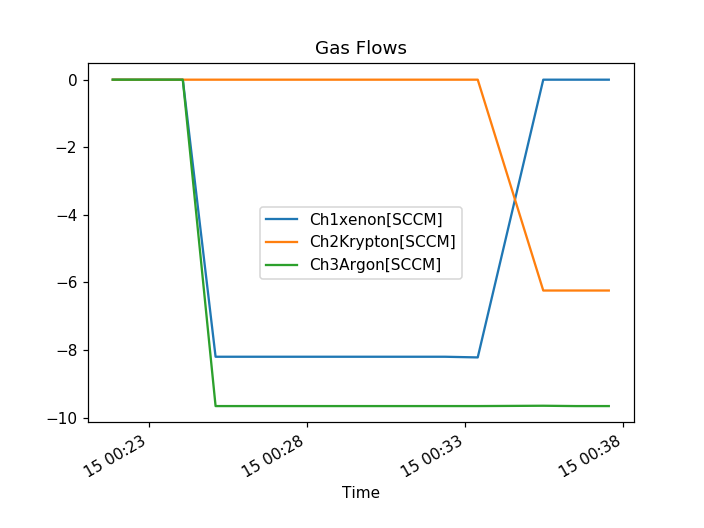

In [21]:
Test.AutoRun(1, True)

In [23]:
Test.EndAutoRun()